CODE BLOCK: 1

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [55]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


CODE BLOCK: 3

In [56]:
# Transforms (use same norm for both)
mnist_mean, mnist_std = (0.1307,), (0.3081,)
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22)], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std),
])

CODE BLOCK: 4

In [57]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data  = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [58]:
batch_size = 128  # smaller gives faster feedback; increase if you want
train_kwargs = {'batch_size': batch_size, 'shuffle': True,  'num_workers': 2, 'pin_memory': cuda}
test_kwargs  = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': cuda}

train_loader = torch.utils.data.DataLoader(train_data, **train_kwargs)
test_loader  = torch.utils.data.DataLoader(test_data,  **test_kwargs)

CODE BLOCK: 6

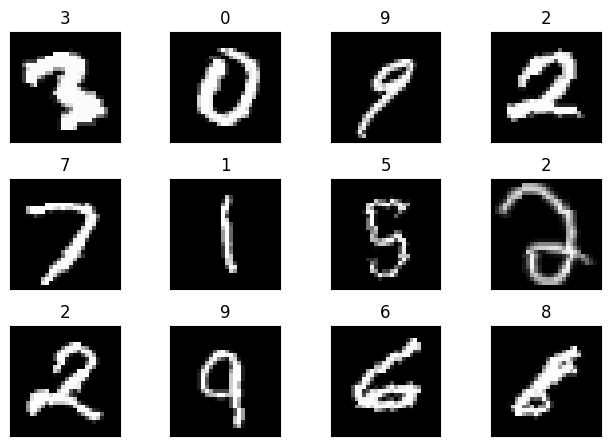

In [59]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [106]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(1, 16, kernel_size=3, padding='same')
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        # self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.conv14 = nn.Conv2d(16, 8, kernel_size=1, padding='same')

        self.conv21 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv22 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        # self.conv23 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.conv24 = nn.Conv2d(16, 8, kernel_size=1, padding='same')

        self.conv31 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv32 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        # self.conv33 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.conv34 = nn.Conv2d(16, 8, kernel_size=1, padding='same')

        self.conv41 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv42 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        # self.conv43 = nn.Conv2d(16, 10, kernel_size=3, padding='same')


    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        # x = F.relu(self.conv13(x))
        x = F.relu(F.max_pool2d(self.conv14(x), 2))

        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        # x = F.relu(self.conv23(x))
        x = F.relu(F.max_pool2d(self.conv24(x), 2))

        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        # x = F.relu(self.conv33(x))
        x = F.relu(F.max_pool2d(self.conv34(x), 2))

        x = F.relu(self.conv41(x))
        # x = F.relu(self.conv42(x))
        x = self.conv42(x)                  # [batch, 10, H, W]
        x = F.adaptive_avg_pool2d(x, (1,1)) # [batch, 10, 1, 1]
        x = torch.flatten(x, 1)             # [batch, 10]
        return x

current_model = Net()
# Calculate the number of trainable parameters
trainable_params = sum(p.numel() for p in current_model.parameters() if p.requires_grad)

print("Number of trainable parameters:", trainable_params)

dummy_data = torch.randn(5, 1, 28, 28)
dummy_output = current_model(dummy_data)
print(dummy_output.shape)

Number of trainable parameters: 13352
torch.Size([5, 16])


CODE BLOCK: 8

In [107]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [113]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


            test_loss /= len(test_loader)

            test_acc.append(100. * correct / len(test_loader.dataset))
            test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [116]:
# model / optimizer / criterion
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam often converges faster
criterion = nn.CrossEntropyLoss()

num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  # scheduler.step()

Epoch 1


Train: Loss=0.4970 Batch_id=468 Accuracy=55.89: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Test set: Average loss: 0.0017, Accuracy: 8885/10000 (88.85%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

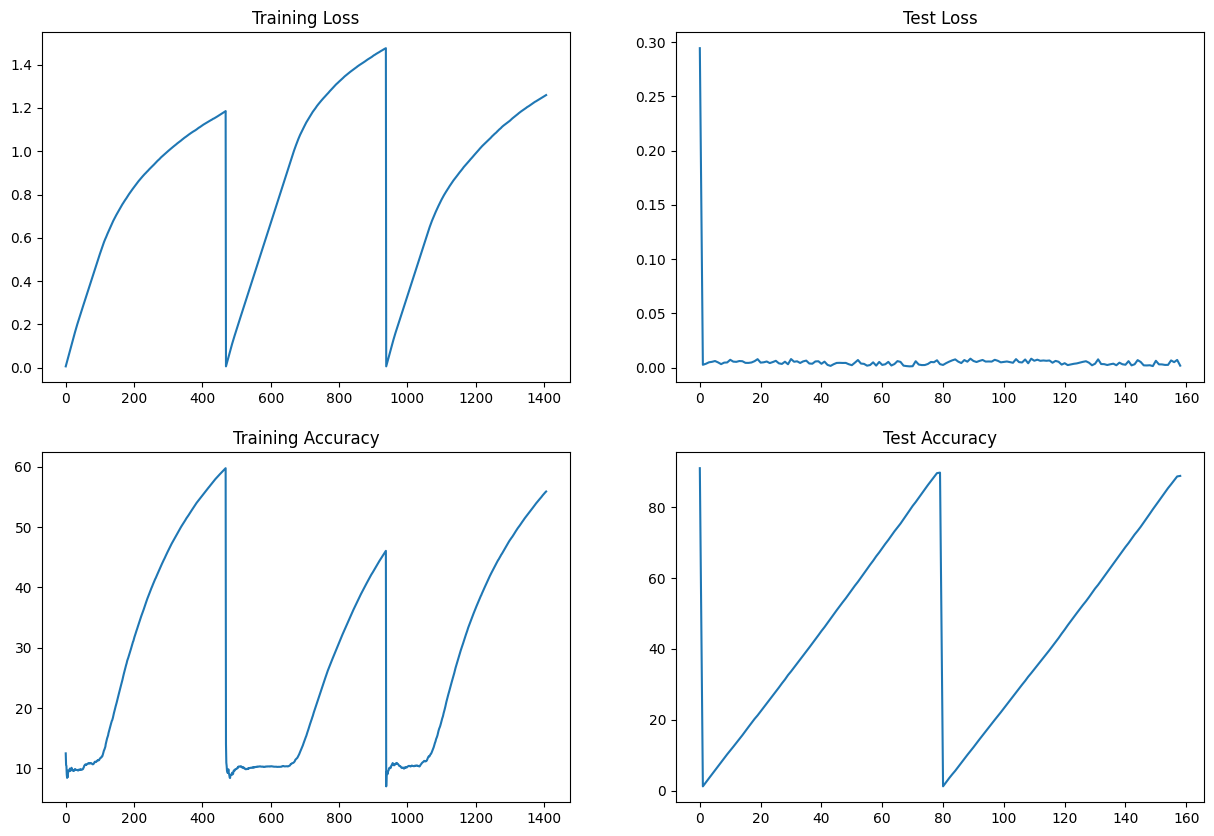

In [117]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")